# Проект по предсказанию токсичности соединений
Что нужно сделать:


1. Проанализировать данные, + за визуализацию
2. Предобработать данные, чтобы улучшить качество модели. + за инсайты, если что-то найдется
3. Обучить модель и провалидировать ее. Метрика: RMSE
4. Проверить модель на test данных и прислать результаты вместе с ноутбуком



## Библиотеки и загрузка данных

rdkit – библиотека для работы с химическими данными.

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from django.contrib.admin import display
from sklearn import metrics
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV, cross_val_score

In [2]:
train = pd.read_csv("train.csv")

In [3]:
train.head()

,SMILES,activity
0,OCC=C,5.0
1,CO/N=C(/C(=O)OC)\C1=C(COC2=C(C)C=CC=C2)C=CC=C1,94.0
2,COC(=O)NS(=O)(=O)C1=CC=C(N)C=C1,5.4
3,CCCCC(CC)C(O)=O,-8.2
4,COC(=O)C1=C(CC(C)C)C(C2=NCCS2)=C(N=C1C(F)F)C(F...,26.2


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759 entries, 0 to 758
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SMILES    759 non-null    object 
 1   activity  759 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.0+ KB


In [5]:
train.describe()

,activity
count,759.000000
mean,40.691304
std,36.150662
min,-38.300000
25%,10.750000
50%,30.100000
75%,69.550000
max,111.000000


In [6]:
display(train['SMILES'].duplicated().value_counts())
display(train['activity'].duplicated().value_counts())

activity
False    518
True     241
Name: count, dtype: int64

## Анализ данных

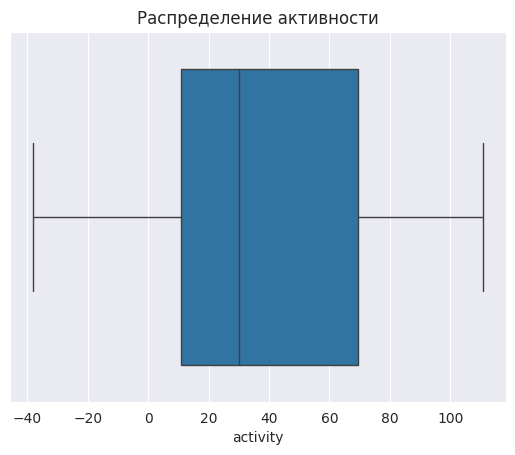

In [7]:
sns.boxplot(x=train['activity'])
plt.title('Распределение активности')
plt.show()

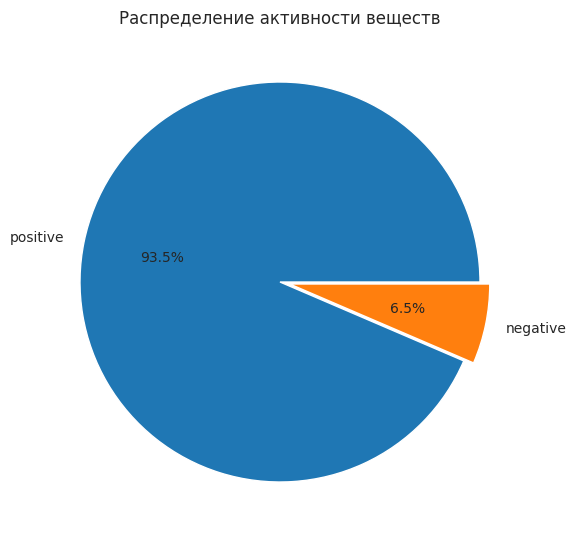

In [8]:
train_copy = train.copy()

def group_activity(activity):
    """"Функция принимает показатель активности и добавляет группу"""
    if activity < 0:
        return 'negative'
    elif activity > 0:
        return 'positive'
    else:
        return 'neutral'

train_copy['activity_group'] = train_copy['activity'].apply(group_activity)

# Группируем данные и получаем количество в каждой категории
mask = train_copy['activity_group'].value_counts()


fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    mask,
    labels=mask.index,
    autopct='%.1f%%',
    explode = [0.0, 0.05]
)
axes.set_title('Распределение активности веществ')
plt.show()


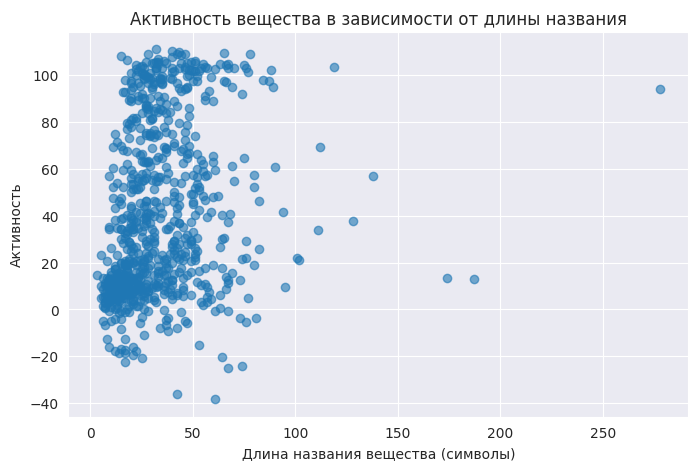

In [9]:
# Создаём новый столбец с длиной названия вещества
train_copy['name_length'] = train['SMILES'].apply(len)

# Строим scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(train_copy['name_length'], train_copy['activity'], alpha=0.6)
plt.title('Активность вещества в зависимости от длины названия')
plt.xlabel('Длина названия вещества (символы)')
plt.ylabel('Активность')
plt.grid(True)
plt.show()

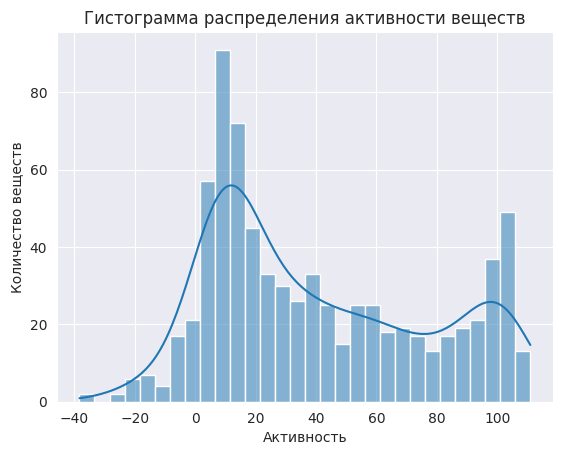

In [10]:
sns.histplot(train['activity'], bins=30, kde=True)
plt.title('Гистограмма распределения активности веществ')
plt.xlabel('Активность')
plt.ylabel('Количество веществ')
plt.show()

> В датасете нет повторяющихся веществ, но у 241 вещества активность одинаковая. Выбросов нет. Только 6.5% веществ обладают отрицательной активностью, нулевой активности нет ни у одного вещества. Подавляющее большинство веществ обладают положительной активностью, активность вещества не зависит от сложности названия.

## Предобработка данных

In [11]:
from rdkit import Chem
from rdkit.Chem import AllChem

SMILES – это форма записи молекулы текстом. Модели не понимают текст (если мы не говорим о специальных моделях), поэтому текст нужно превратить в числа. Один из способов превратить молекулы в числа – это fingerprints.

In [12]:
def smiles_to_fp(smiles):
    '''Convert SMILES to Morgan fingerprints'''
    return np.array([AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), 2, nBits=1024) for s in smiles])

X = smiles_to_fp(train.SMILES)
y = train['activity'].values

[23:52:57] DEPRECATION WARNING: please use MorganGenerator
[23:52:57] DEPRECATION WARNING: please use MorganGenerator
[23:52:57] DEPRECATION WARNING: please use MorganGenerator
[23:52:57] DEPRECATION WARNING: please use MorganGenerator
[23:52:57] DEPRECATION WARNING: please use MorganGenerator
[23:52:57] DEPRECATION WARNING: please use MorganGenerator
[23:52:57] DEPRECATION WARNING: please use MorganGenerator
[23:52:57] DEPRECATION WARNING: please use MorganGenerator
[23:52:57] DEPRECATION WARNING: please use MorganGenerator
[23:52:57] DEPRECATION WARNING: please use MorganGenerator
[23:52:57] DEPRECATION WARNING: please use MorganGenerator
[23:52:57] DEPRECATION WARNING: please use MorganGenerator
[23:52:57] DEPRECATION WARNING: please use MorganGenerator
[23:52:57] DEPRECATION WARNING: please use MorganGenerator
[23:52:57] DEPRECATION WARNING: please use MorganGenerator
[23:52:57] DEPRECATION WARNING: please use MorganGenerator
[23:52:57] DEPRECATION WARNING: please use MorganGenerat

## Обучение модели

In [23]:
#Создаём объект класса случайный лес
model = ensemble.RandomForestRegressor(
    n_estimators=300, #число деревьев
    max_features='sqrt',
    random_state=42 #генератор случайных чисел
)

# Разделение данных на обучающую и тестовую выборки (80% на обучение, 20% на тест)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Обучаем модель 
model.fit(X_train, y_train)

#Делаем предсказание класса
y_pred = model.predict(X_test)

# Рассчитаем MSE
mse = mean_squared_error(y_test, y_pred)

# Рассчитаем RMSE
rmse = np.sqrt(mse)

print("RMSE на тестовых данных:", round(rmse, 2))

RMSE на тестовых данных: 25.84
